<h4>
<ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">OBJECTIVE:</span></strong></li>
</ul>
<p><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use the text data to build a deep-learning based binary classifier.</span></p>
    </h4>

In [1]:
# imports

import warnings
warnings.filterwarnings('ignore')

import os
import math
import random
from time import time
from pathlib import Path
import pandas as pd, numpy as np
from pprint import pprint
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import defaultdict, Counter
from sklearn.preprocessing import LabelEncoder
from wordcloud import WordCloud, STOPWORDS
import tensorflow

tqdm.pandas()
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [2]:
# reproducibility
seed = 7
random.seed(seed)
tensorflow.random.set_seed(seed)

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Import the clean data.</span></strong></li>
</ul></h3>

In [3]:
dataset = pd.read_csv('./data/augmented_upsampled_data.csv')
dataset.sample(10)

,translated_description,label
4543,outlook start,0
12915,password account expires,1
17197,Need help changing password password managemen...,0
12943,nanrfakurtyar send Monday pm dba subject pl ch...,1
7027,see attachment discritpion discription show co...,1
12068,log on phone software error message phone auth...,1
9686,host name volume label sys host name ab space ...,1
25738,work work failure work programmer work,1
22344,dwnload prb try downloading desktop engineerin...,0
9451,I tool and batch management is not working,1


In [4]:
dataset.isna().sum()

translated_description    0
label                     0
dtype: int64

In [5]:
dataset.label.value_counts()

1    13109
0    13109
Name: label, dtype: int64

In [6]:
X = np.array(dataset.translated_description)
y = np.array(dataset.label)
X.shape, y.shape

((26218,), (26218,))

In [7]:
from tensorflow.keras.utils import to_categorical
y_dummy_coded = to_categorical(y)
y[0], y_dummy_coded[0]

(0, array([1., 0.], dtype=float32))

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_dummy_coded, test_size=.15,
                                                    random_state=seed, stratify=y_dummy_coded)  # splits are stratified by y

In [9]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((22285,), (3933,), (22285, 2), (3933, 2))

In [10]:
X_train[0], y_train[0]  # check sample

('forget password erp sid  make  attempt fail could reset user dgrtrkjs',
 array([1., 0.], dtype=float32))

In [11]:
# TODO: Check the distributions of groups in training and testing sets, i.e, if they vary too much
# stratify by y if required during splits
# or data augmentation to upsample minority classes to balance the group distributions

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Tokenize and pad sequences</span></strong></li>
</ul></h3>

In [12]:
# define params
NUM_WORDS = 20000
EMBEDDING_DIM = 300
MAX_LEN = 100 # dataset['word_length'].max()
MAX_LEN

100

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(num_words=NUM_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)
X_train_tokens[0], X_test_tokens[0]

([1127, 5, 8, 20, 165, 450, 46, 87, 22, 11, 9816],
 [396,
  107,
  1881,
  669,
  16,
  8,
  7444,
  206,
  7,
  1735,
  375,
  15,
  2868,
  206,
  288,
  7,
  484,
  84,
  320,
  234,
  179])

In [14]:
y_train[0], y_test[0]

(array([1., 0.], dtype=float32), array([0., 1.], dtype=float32))

In [15]:
# pad sequences to cut longer texts to a uniform length and pad the sentences that are shorter than that with <PAD> token

# using just 20 words from each headline will severely limit the information that is 
# available to the model and affect performance although the training will be faster
X_train_padded = pad_sequences(X_train_tokens,
                               padding='post',
                               truncating='post',
                               maxlen=MAX_LEN)
X_test_padded = pad_sequences(X_test_tokens,
                              padding='post',
                              truncating='post',
                              maxlen=MAX_LEN)


print(f'X train:  {X_train_padded.shape}\nX test:   {X_test_padded.shape}')

X train:  (22285, 100)
X test:   (3933, 100)


In [16]:
pprint(X_train_padded[0], compact=True)

array([1127,    5,    8,   20,  165,  450,   46,   87,   22,   11, 9816,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0])


In [17]:
WORD_TO_INDEX = tokenizer.word_index
# pprint(WORD_TO_INDEX, compact=True)
pprint(list(WORD_TO_INDEX.keys())[:100], compact=True)

['u', 'work', 'system', 'the', 'password', 'ts', 'tool', 'erp', 'job',
 'company', 'user', 'plant', 'to', 'security', 'error', 'problem', 'of',
 'access', 'account', 'sid', 'need', 'reset', 'use', 'help', 'get', 'ticket',
 'hostname', 'message', 'printer', 'issue', 'email', 'window', 'order', 'time',
 'engineering', 'failure', 'connection', 'new', 'change', 'site', 'check',
 'scheduler', 'name', 'see', 'request', 'fail', 'update', 'information',
 'login', 'a', 'phone', 'send', 'contact', 'unable', 'server', 'or', 'and',
 'streaming', 'with', 'create', 'try', 'germany', 'type', 'log', 'crm',
 'network', 'open', 'team', 'e', 'report', 't', 'show', 'game', 'call', 'pc',
 'is', 'backup', 'number', 'i', 'management', 'print', 'in', 'not', 'view',
 'receive', 'circuit', 'could', 'file', 'programmer', 'connect', 'no',
 'delivery', 'outlook', 'mail', 'sale', 'also', 'software', 'production',
 'start', 'customer']


In [18]:
VOCAB_SIZE = len(WORD_TO_INDEX) + 1
VOCAB_SIZE

13348

In [19]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def retrieve_description_feat(x, mapping=WORD_TO_INDEX) -> str:
    # increment 3 
    mapping = {k:(v + 3) for k, v in mapping.items()}
    mapping['<PAD>'] = 0
    mapping['<START>'] = 1
    mapping['<UNK>'] = 2
    inv_mapping = {v: k for k, v in mapping.items()}
    return str(" ".join(inv_mapping.get(i, '<NA>') for i in x))

retrieve_description_feat(X_test_padded[7])

'problem find <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD>'

<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">GloVe Embeddings</span></strong></li>
</ul></h3>

In [20]:
EMBEDDING_DIM

300

In [21]:
def get_embedding_matrix(embedding_dim=EMBEDDING_DIM):
    embeddings = defaultdict()
    if embedding_dim == 200:
        file_path = f'./data/glove.6B.{embedding_dim}d.txt'
    elif embedding_dim == 300:
        file_path = f'./data/glove.840B.{embedding_dim}d.txt'
    for l in open(file_path, encoding='utf-8'):
        word = l.split(" ")[0]
        embeddings[word] = np.asarray(l.split(" ")[1:], dtype='float32')

    embeddings = dict(embeddings)

    # create a weight matrix for words in training docs
    embedding_matrix = np.zeros((NUM_WORDS, embedding_dim))

    for word, idx in WORD_TO_INDEX.items():
        embedding_vector = embeddings.get(word)
        if embedding_vector is not None:
            embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [22]:
# use pre-trained glove embedding matrix to initialize weights in our model
embedding_matrix = get_embedding_matrix()
embedding_matrix.shape

(20000, 300)

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net</span></strong></li>
</ul></h4>

In [23]:
# !pip install livelossplot
from tensorflow.python.keras.models import Sequential
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm, unit_norm
from tensorflow.python.keras.callbacks import LambdaCallback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Activation, BatchNormalization, Dropout, Embedding, LSTM, MaxPooling1D, Conv1D, Bidirectional

In [24]:
NUM_CLASSES = 2
VOCAB_SIZE, MAX_LEN, EMBEDDING_DIM, NUM_CLASSES

(13348, 100, 300, 2)

In [25]:
# define model

model1 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(1024, activation = 'relu'),
    Dense(1024, activation = 'relu'),
    Dense(128, activation = 'relu'),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model1.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [26]:
# Define Callbacks and a few helper functions

# simplify the training log
simple_log = LambdaCallback(
    on_epoch_end = lambda e, l: print(f" ~| Epoch: {e+1} | Validation Loss: {l['val_loss']:.5f}", end =" >|> \n" ))

# early stopping
early_stop = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=7,
                              verbose=0, 
                              restore_best_weights=True)

# learning rate reduction
lr_reduce_on_plateau = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=4, 
                                            verbose=1, 
                                            factor=0.4,
                                            min_lr=0.00001)

def plot_learning_curve(hist):
    sns.set()
    plt.figure(figsize=(5,5))
    train = hist.history['loss']
    val = hist.history['val_loss']
    epochs_run = range(1,len(train) + 1)
    sns.lineplot(epochs_run, train, marker = 'o', color = 'coral', label = 'Training Loss')
    sns.lineplot(epochs_run, val,  marker = '>', color = 'green', label = 'Validation Loss')
    plt.title("Loss vs. Epochs", fontsize = 20)
    plt.legend()
    plt.show()

In [27]:
X_train[0]

'forget password erp sid  make  attempt fail could reset user dgrtrkjs'

In [28]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((22285,), (22285, 2), (3933,), (3933, 2))

In [29]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("\nTraining on CPU:")
    h1 = model1.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.26657 >|> 
 ~| Epoch: 2 | Validation Loss: 0.27698 >|> 
 ~| Epoch: 3 | Validation Loss: 0.27947 >|> 
 ~| Epoch: 4 | Validation Loss: 0.29024 >|> 
 ~| Epoch: 5 | Validation Loss: 0.33299 >|> 
 ~| Epoch: 6 | Validation Loss: 0.35967 >|> 
 ~| Epoch: 7 | Validation Loss: 0.31667 >|> 
 ~| Epoch: 8 | Validation Loss: 0.41147 >|> 

Training Done.


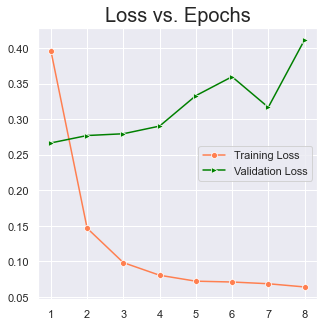

In [30]:
plot_learning_curve(h1)

In [31]:
loss, acc = model1.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 0s 3ms/step - loss: 0.2686 - accuracy: 0.8863
Testing Loss:  26.855483651161194
Testing Accuracy:  88.63462805747986


<h4><ul>
<span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">
    <li>This model is clearly overfitting, we will add regularization to the next iteration
 </span></ul></h4>

<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Batch Normalization</span></strong></li>
</ul></h4>

In [32]:
# define model

model2 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(256, activation = 'relu'),
    BatchNormalization(),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model2.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [33]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h2 = model2.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.35288 >|> 
 ~| Epoch: 2 | Validation Loss: 0.26205 >|> 
 ~| Epoch: 3 | Validation Loss: 0.27754 >|> 
 ~| Epoch: 4 | Validation Loss: 0.39938 >|> 
 ~| Epoch: 5 | Validation Loss: 0.77244 >|> 
 ~| Epoch: 6 | Validation Loss: 0.26548 >|> 
 ~| Epoch: 7 | Validation Loss: 0.37249 >|> 
 ~| Epoch: 8 | Validation Loss: 0.30677 >|> 
 ~| Epoch: 9 | Validation Loss: 0.41319 >|> 

Training Done.


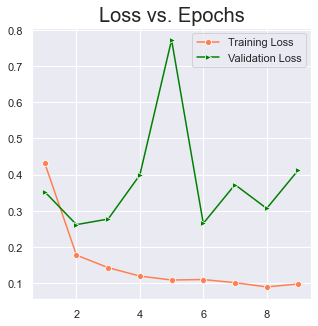

In [34]:
plot_learning_curve(h2)

In [35]:
loss, acc = model2.evaluate(X_test_padded, y_test)
print("Testing Loss: ", loss*100)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 0s 3ms/step - loss: 0.2640 - accuracy: 0.9013
Testing Loss:  26.402437686920166
Testing Accuracy:  90.13475775718689


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Simple Feed-Forward Neural Net + Dropout</span></strong></li>
</ul></h4>

In [36]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Flatten(),
    Dense(20, activation = 'relu'),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [37]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.27458 >|> 
 ~| Epoch: 2 | Validation Loss: 0.23892 >|> 
 ~| Epoch: 3 | Validation Loss: 0.25674 >|> 
 ~| Epoch: 4 | Validation Loss: 0.28678 >|> 
 ~| Epoch: 5 | Validation Loss: 0.27314 >|> 
 ~| Epoch: 6 | Validation Loss: 0.36057 >|> 

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 7 | Validation Loss: 0.37500 >|> 
 ~| Epoch: 8 | Validation Loss: 0.39637 >|> 
 ~| Epoch: 9 | Validation Loss: 0.41275 >|> 

Training Done.


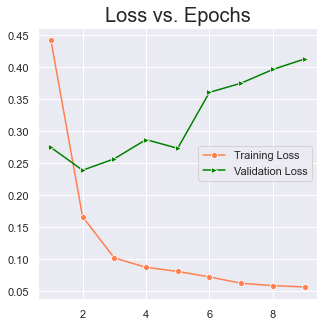

In [38]:
plot_learning_curve(h3)

In [39]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 0s 3ms/step - loss: 0.2469 - accuracy: 0.9021
Testing Accuracy:  90.21103382110596


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use pre-trained embeddings</span></strong></li>
</ul></h4>

In [40]:
# define model

model3 = Sequential([ 
    Embedding(input_dim=NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_LEN, weights=[embedding_matrix], trainable=True),
    Flatten(),
    Dense(30, activation = 'relu'),
    Dropout(0.5),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model3.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [41]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h3 = model3.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.42110 >|> 
 ~| Epoch: 2 | Validation Loss: 0.36518 >|> 
 ~| Epoch: 3 | Validation Loss: 0.34072 >|> 
 ~| Epoch: 4 | Validation Loss: 0.35497 >|> 
 ~| Epoch: 5 | Validation Loss: 0.35743 >|> 
 ~| Epoch: 6 | Validation Loss: 0.33771 >|> 
 ~| Epoch: 7 | Validation Loss: 0.43173 >|> 
 ~| Epoch: 8 | Validation Loss: 0.46950 >|> 
 ~| Epoch: 9 | Validation Loss: 0.50198 >|> 
 ~| Epoch: 10 | Validation Loss: 0.48442 >|> 
 ~| Epoch: 11 | Validation Loss: 0.49287 >|> 
 ~| Epoch: 12 | Validation Loss: 0.55885 >|> 
 ~| Epoch: 13 | Validation Loss: 0.70739 >|> 

Training Done.


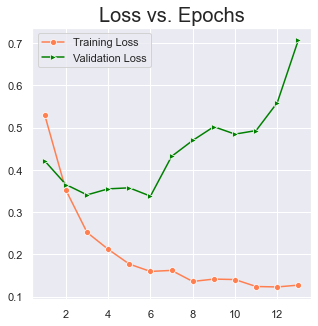

In [42]:
plot_learning_curve(h3)

In [43]:
loss, acc = model3.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 0s 3ms/step - loss: 0.3594 - accuracy: 0.8912
Testing Accuracy:  89.1177237033844


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">LSTM</span></strong></li>
</ul></h4>

In [44]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    LSTM(32),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [45]:
EPOCHS = 50
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.69252 >|> 
 ~| Epoch: 2 | Validation Loss: 0.69072 >|> 
 ~| Epoch: 3 | Validation Loss: 0.68769 >|> 
 ~| Epoch: 4 | Validation Loss: 0.68089 >|> 
 ~| Epoch: 5 | Validation Loss: 0.68698 >|> 
 ~| Epoch: 6 | Validation Loss: 0.50315 >|> 
 ~| Epoch: 7 | Validation Loss: 0.41877 >|> 
 ~| Epoch: 8 | Validation Loss: 0.40158 >|> 
 ~| Epoch: 9 | Validation Loss: 0.38546 >|> 
 ~| Epoch: 10 | Validation Loss: 0.37950 >|> 
 ~| Epoch: 11 | Validation Loss: 0.37468 >|> 
 ~| Epoch: 12 | Validation Loss: 0.37197 >|> 
 ~| Epoch: 13 | Validation Loss: 0.34412 >|> 
 ~| Epoch: 14 | Validation Loss: 0.33276 >|> 
 ~| Epoch: 15 | Validation Loss: 0.34234 >|> 
 ~| Epoch: 16 | Validation Loss: 0.35067 >|> 
 ~| Epoch: 17 | Validation Loss: 0.31887 >|> 
 ~| Epoch: 18 | Validation Loss: 0.31449 >|> 
 ~| Epoch: 19 | Validation Loss: 0.34424 >|> 
 ~| Epoch: 20 | Validation Loss: 0.28826 >|> 
 ~| Epoch: 21 | Validation Loss: 0.32609 >|> 
 ~| Epoch: 22 | Validation

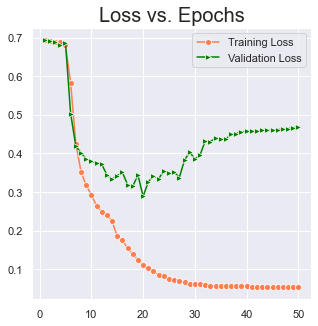

In [46]:
plot_learning_curve(h4)

In [47]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 1s 5ms/step - loss: 0.4922 - accuracy: 0.9158
Testing Accuracy:  91.58403277397156


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [48]:
# define model

model4 = Sequential([ 
    Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(32)),
    Dropout(0.4),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model4.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [49]:
EPOCHS = 200
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h4 = model4.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.35770 >|> 
 ~| Epoch: 2 | Validation Loss: 0.32140 >|> 
 ~| Epoch: 3 | Validation Loss: 0.27678 >|> 
 ~| Epoch: 4 | Validation Loss: 0.26556 >|> 
 ~| Epoch: 5 | Validation Loss: 0.25546 >|> 
 ~| Epoch: 6 | Validation Loss: 0.25183 >|> 
 ~| Epoch: 7 | Validation Loss: 0.23724 >|> 
 ~| Epoch: 8 | Validation Loss: 0.28229 >|> 
 ~| Epoch: 9 | Validation Loss: 0.24514 >|> 
 ~| Epoch: 10 | Validation Loss: 0.24821 >|> 
 ~| Epoch: 11 | Validation Loss: 0.25777 >|> 

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 12 | Validation Loss: 0.24529 >|> 
 ~| Epoch: 13 | Validation Loss: 0.25186 >|> 
 ~| Epoch: 14 | Validation Loss: 0.25276 >|> 

Training Done.


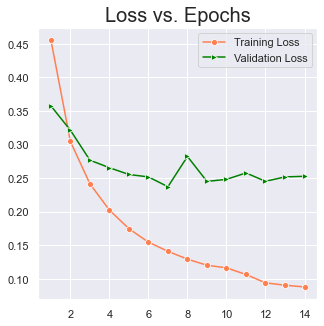

In [50]:
plot_learning_curve(h4)

In [51]:
loss, acc = model4.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 1s 6ms/step - loss: 0.2224 - accuracy: 0.9133
Testing Accuracy:  91.3297712802887


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + LSTM</span></strong></li>
</ul></h4>

In [52]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    LSTM(75),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [53]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop, lr_reduce_on_plateau],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.35572 >|> 
 ~| Epoch: 2 | Validation Loss: 0.27669 >|> 
 ~| Epoch: 3 | Validation Loss: 0.26382 >|> 
 ~| Epoch: 4 | Validation Loss: 0.25972 >|> 
 ~| Epoch: 5 | Validation Loss: 0.22674 >|> 
 ~| Epoch: 6 | Validation Loss: 0.30527 >|> 
 ~| Epoch: 7 | Validation Loss: 0.25744 >|> 
 ~| Epoch: 8 | Validation Loss: 0.25456 >|> 
 ~| Epoch: 9 | Validation Loss: 0.26326 >|> 

Epoch 00009: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
 ~| Epoch: 10 | Validation Loss: 0.31021 >|> 
 ~| Epoch: 11 | Validation Loss: 0.29070 >|> 
 ~| Epoch: 12 | Validation Loss: 0.29581 >|> 

Training Done.


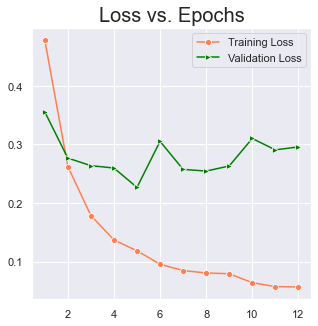

In [54]:
plot_learning_curve(h5)

In [55]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 1s 5ms/step - loss: 0.2275 - accuracy: 0.9166
Testing Accuracy:  91.66030883789062


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">CNN (Dimensionality Reduction) + Bi-Directional LSTM</span></strong></li>
</ul></h4>

In [56]:
model5 = Sequential([
    Embedding(input_dim=VOCAB_SIZE, output_dim=256, input_length=MAX_LEN),
    Dropout(0.25),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    Conv1D(256, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Conv1D(64, 5, padding = 'same', activation = 'relu', strides = 1),
    MaxPooling1D(pool_size = 2),
    Bidirectional(LSTM(75, recurrent_dropout=0.5)),
    Dense(NUM_CLASSES, activation = 'softmax')
])

model5.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [57]:
EPOCHS = 20
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception as e:
    print(e)
    print("Training on CPU:")
    h5 = model5.fit(
            X_train_padded, y_train,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.29827 >|> 
 ~| Epoch: 2 | Validation Loss: 0.25080 >|> 
 ~| Epoch: 3 | Validation Loss: 0.21678 >|> 
 ~| Epoch: 4 | Validation Loss: 0.27556 >|> 
 ~| Epoch: 5 | Validation Loss: 0.25120 >|> 
 ~| Epoch: 6 | Validation Loss: 0.28130 >|> 
 ~| Epoch: 7 | Validation Loss: 0.26769 >|> 
 ~| Epoch: 8 | Validation Loss: 0.26127 >|> 
 ~| Epoch: 9 | Validation Loss: 0.28917 >|> 
 ~| Epoch: 10 | Validation Loss: 0.29104 >|> 

Training Done.


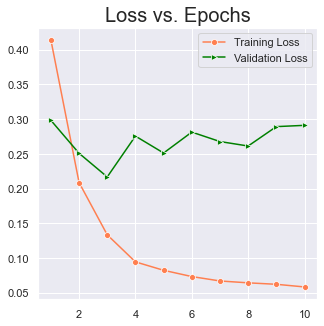

In [58]:
plot_learning_curve(h5)

In [59]:
loss, acc = model5.evaluate(X_test_padded, y_test)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 5s 45ms/step - loss: 0.2261 - accuracy: 0.9169
Testing Accuracy:  91.6857361793518


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection</span></strong></li>
</ul></h4>

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# using 75-25 split instead of 50-50 split as we need more data to train neural nets
X_train_vec, X_test_vec, y_train_vec, y_test_vec = train_test_split(X, y, test_size=0.15, random_state=seed, stratify=y)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (22285,), 
Test dataset shape: (3933,)


In [61]:
NGRAM_RANGE = (1, 3)
TOP_K = 8500
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2


kwargs = {
    'ngram_range' : NGRAM_RANGE,
    'dtype' : 'int32',
    'strip_accents' : 'unicode',
    'decode_error' : 'replace',
    'analyzer' : TOKEN_MODE,
    'min_df' : MIN_DOC_FREQ
}
vectorizer = TfidfVectorizer(**kwargs)
X_train_vec = vectorizer.fit_transform(X_train_vec)
X_test_vec = vectorizer.transform(X_test_vec)
print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (22285, 119901), 
Test dataset shape: (3933, 119901)


In [62]:
from sklearn.feature_selection import SelectKBest, f_classif

# Select best k features, with feature importance measured by f_classif
# Set k as 20000 or (if number of ngrams is less) number of ngrams   
selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
selector.fit(X_train_vec, y_train_vec)
X_train_vec = selector.transform(X_train_vec).astype('float32')
X_test_vec = selector.transform(X_test_vec).astype('float32')
X_train_vec = X_train_vec.toarray()
X_test_vec = X_test_vec.toarray()

print(f"Train dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

Train dataset shape: (22285, 8500), 
Test dataset shape: (3933, 8500)


In [63]:
model6 = Sequential([
    Dense(30, activation='relu', input_shape=X_train_vec.shape[1:]),
    Dropout(0.5),
    Dense(20, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model6.compile(
    loss = 'binary_crossentropy',
    optimizer = 'rmsprop',
    metrics = ['accuracy']
)

In [64]:
EPOCHS = 50
try:
    print("Training on GPU:")
    with tensorflow.device("gpu:0"):  # train on gpu
        h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)
except Exception:
    print("Training on CPU:")
    h6 = model6.fit(
            X_train_vec, y_train_vec,
            validation_split = 0.2,  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [simple_log, early_stop],
            verbose = False)

print("\nTraining Done.")

Training on GPU:
 ~| Epoch: 1 | Validation Loss: 0.44404 >|> 
 ~| Epoch: 2 | Validation Loss: 0.38773 >|> 
 ~| Epoch: 3 | Validation Loss: 0.37772 >|> 
 ~| Epoch: 4 | Validation Loss: 0.37140 >|> 
 ~| Epoch: 5 | Validation Loss: 0.36992 >|> 
 ~| Epoch: 6 | Validation Loss: 0.36377 >|> 
 ~| Epoch: 7 | Validation Loss: 0.35798 >|> 
 ~| Epoch: 8 | Validation Loss: 0.35687 >|> 
 ~| Epoch: 9 | Validation Loss: 0.35434 >|> 
 ~| Epoch: 10 | Validation Loss: 0.35774 >|> 
 ~| Epoch: 11 | Validation Loss: 0.35099 >|> 
 ~| Epoch: 12 | Validation Loss: 0.36085 >|> 
 ~| Epoch: 13 | Validation Loss: 0.35106 >|> 
 ~| Epoch: 14 | Validation Loss: 0.34974 >|> 
 ~| Epoch: 15 | Validation Loss: 0.35140 >|> 
 ~| Epoch: 16 | Validation Loss: 0.35375 >|> 
 ~| Epoch: 17 | Validation Loss: 0.35468 >|> 
 ~| Epoch: 18 | Validation Loss: 0.35044 >|> 
 ~| Epoch: 19 | Validation Loss: 0.35326 >|> 
 ~| Epoch: 20 | Validation Loss: 0.35471 >|> 
 ~| Epoch: 21 | Validation Loss: 0.35229 >|> 

Training Done.


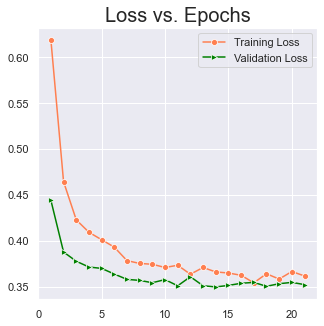

In [65]:
plot_learning_curve(h6)

In [66]:
loss, acc = model6.evaluate(X_test_vec, y_test_vec)
print("Testing Accuracy: ", acc*100)

123/123 [==============================] - 0s 2ms/step - loss: 0.4017 - accuracy: 0.8474
Testing Accuracy:  84.74447131156921


<h4><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Use TfIdf vectors instead of Embedding Layer + Feature Selection + Stratified KFold Training</span></strong></li>
</ul></h4>


Train dataset shape: (25169, 65104), 
Test dataset shape: (1049, 65104)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.86559, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00002: val_accuracy improved from 0.86559 to 0.88084, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00003: val_accuracy improved from 0.88084 to 0.89228, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00004: val_accuracy improved from 0.89228 to 0.89514, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00005: val_accuracy improved from 0.89514 to 0.90944, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00006: val_accuracy improved from 0.90944 to 0.91134, saving model to models\binary_classfiier\dl\merged_descr\model_1.h5

Epoch 00007: val_accuracy did not improve from 0.91134

Epoch 000

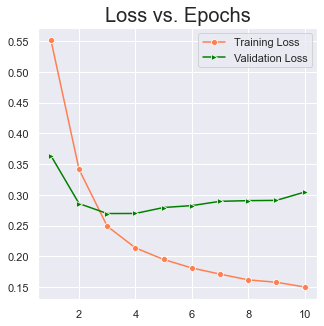

33/33 [==============================] - 0s 3ms/step - loss: 0.2826 - accuracy: 0.9113
Testing Accuracy:  91.13441109657288

Train dataset shape: (25169, 65060), 
Test dataset shape: (1049, 65060)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.86749, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00002: val_accuracy improved from 0.86749 to 0.88847, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00003: val_accuracy improved from 0.88847 to 0.90658, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00004: val_accuracy did not improve from 0.90658

Epoch 00005: val_accuracy improved from 0.90658 to 0.90753, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00006: val_accuracy improved from 0.90753 to 0.91325, saving model to models\binary_classfiier\dl\merged_descr\model_2.h5

Epoch 00007: v

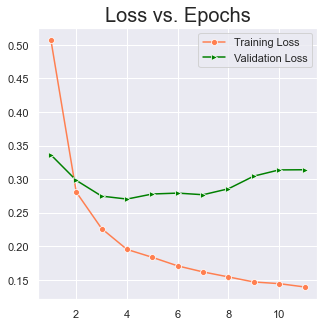

33/33 [==============================] - 0s 2ms/step - loss: 0.3045 - accuracy: 0.9237
Testing Accuracy:  92.37368702888489

Train dataset shape: (25169, 65072), 
Test dataset shape: (1049, 65072)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.86463, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00002: val_accuracy improved from 0.86463 to 0.89514, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00003: val_accuracy improved from 0.89514 to 0.90086, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00004: val_accuracy improved from 0.90086 to 0.90848, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00005: val_accuracy improved from 0.90848 to 0.91706, saving model to models\binary_classfiier\dl\merged_descr\model_3.h5

Epoch 00006: val_accuracy improved from 0.91706 to 0.92469, saving mod

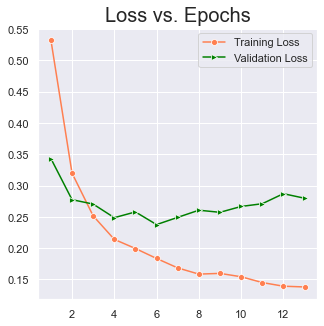

33/33 [==============================] - 0s 3ms/step - loss: 0.2797 - accuracy: 0.9295
Testing Accuracy:  92.94566512107849

Train dataset shape: (25169, 65170), 
Test dataset shape: (1049, 65170)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88561, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00002: val_accuracy improved from 0.88561 to 0.90562, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00003: val_accuracy improved from 0.90562 to 0.91516, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00004: val_accuracy improved from 0.91516 to 0.91992, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00005: val_accuracy improved from 0.91992 to 0.92755, saving model to models\binary_classfiier\dl\merged_descr\model_4.h5

Epoch 00006: val_accuracy did not improve from 0.92755

Epoch 00007: v

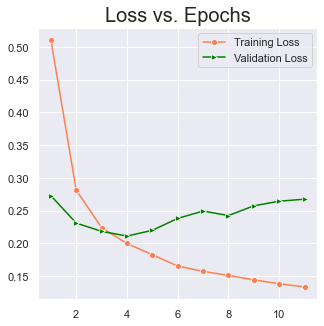

33/33 [==============================] - 0s 3ms/step - loss: 0.2676 - accuracy: 0.9333
Testing Accuracy:  93.32697987556458

Train dataset shape: (25169, 64872), 
Test dataset shape: (1049, 64872)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88179, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00002: val_accuracy improved from 0.88179 to 0.90753, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00003: val_accuracy did not improve from 0.90753

Epoch 00004: val_accuracy improved from 0.90753 to 0.91706, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00005: val_accuracy improved from 0.91706 to 0.92278, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00006: val_accuracy improved from 0.92278 to 0.92374, saving model to models\binary_classfiier\dl\merged_descr\model_5.h5

Epoch 00007: v

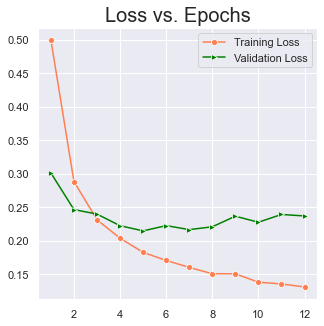

33/33 [==============================] - 0s 3ms/step - loss: 0.2389 - accuracy: 0.9352
Testing Accuracy:  93.51763725280762

Train dataset shape: (25169, 65005), 
Test dataset shape: (1049, 65005)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88656, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00002: val_accuracy improved from 0.88656 to 0.91230, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00003: val_accuracy improved from 0.91230 to 0.92564, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00004: val_accuracy improved from 0.92564 to 0.92755, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00005: val_accuracy improved from 0.92755 to 0.93327, saving model to models\binary_classfiier\dl\merged_descr\model_6.h5

Epoch 00006: val_accuracy improved from 0.93327 to 0.93613, saving mod

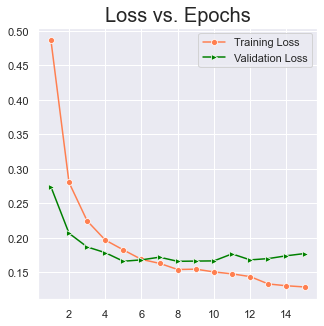

33/33 [==============================] - 0s 2ms/step - loss: 0.1773 - accuracy: 0.9390
Testing Accuracy:  93.8989520072937

Train dataset shape: (25169, 64979), 
Test dataset shape: (1049, 64979)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87798, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00002: val_accuracy improved from 0.87798 to 0.88942, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00003: val_accuracy improved from 0.88942 to 0.90181, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00004: val_accuracy did not improve from 0.90181

Epoch 00005: val_accuracy improved from 0.90181 to 0.90372, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00006: val_accuracy improved from 0.90372 to 0.90944, saving model to models\binary_classfiier\dl\merged_descr\model_7.h5

Epoch 00006: Re

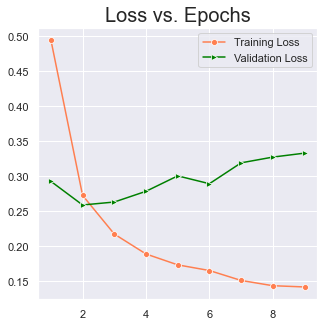

33/33 [==============================] - 0s 3ms/step - loss: 0.3274 - accuracy: 0.9123
Testing Accuracy:  91.22974276542664

Train dataset shape: (25169, 64960), 
Test dataset shape: (1049, 64960)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87893, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00002: val_accuracy improved from 0.87893 to 0.90276, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00003: val_accuracy improved from 0.90276 to 0.91230, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00004: val_accuracy improved from 0.91230 to 0.91420, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00005: val_accuracy did not improve from 0.91420

Epoch 00006: val_accuracy improved from 0.91420 to 0.92946, saving model to models\binary_classfiier\dl\merged_descr\model_8.h5

Epoch 00007: v

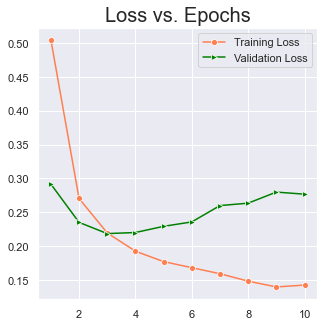

33/33 [==============================] - 0s 3ms/step - loss: 0.2359 - accuracy: 0.9295
Testing Accuracy:  92.94566512107849

Train dataset shape: (25169, 65089), 
Test dataset shape: (1049, 65089)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87989, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00002: val_accuracy improved from 0.87989 to 0.90181, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00003: val_accuracy improved from 0.90181 to 0.91897, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00004: val_accuracy improved from 0.91897 to 0.91992, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00005: val_accuracy did not improve from 0.91992

Epoch 00006: val_accuracy improved from 0.91992 to 0.92278, saving model to models\binary_classfiier\dl\merged_descr\model_9.h5

Epoch 00007: v

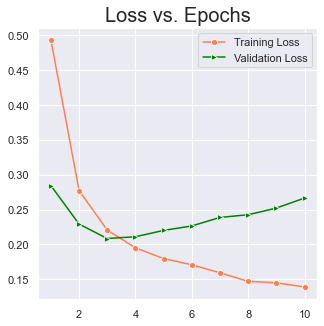

33/33 [==============================] - 0s 3ms/step - loss: 0.2387 - accuracy: 0.9247
Testing Accuracy:  92.46901869773865

Train dataset shape: (25169, 64969), 
Test dataset shape: (1049, 64969)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88179, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00002: val_accuracy improved from 0.88179 to 0.89609, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00003: val_accuracy improved from 0.89609 to 0.89990, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00004: val_accuracy did not improve from 0.89990

Epoch 00005: val_accuracy improved from 0.89990 to 0.90276, saving model to models\binary_classfiier\dl\merged_descr\model_10.h5

Epoch 00006: val_accuracy did not improve from 0.90276

Epoch 00007: val_accuracy did not improve from 0.90276

Epoch 00008: val_accuracy i

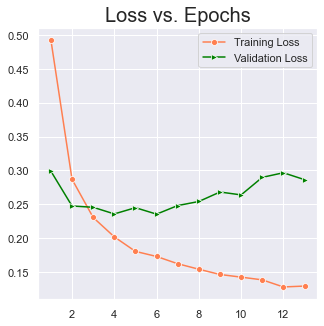

33/33 [==============================] - 0s 3ms/step - loss: 0.2964 - accuracy: 0.9094
Testing Accuracy:  90.94375371932983

Train dataset shape: (25169, 65113), 
Test dataset shape: (1049, 65113)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87321, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00002: val_accuracy improved from 0.87321 to 0.89418, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00003: val_accuracy improved from 0.89418 to 0.89704, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00004: val_accuracy did not improve from 0.89704

Epoch 00005: val_accuracy improved from 0.89704 to 0.90944, saving model to models\binary_classfiier\dl\merged_descr\model_11.h5

Epoch 00006: val_accuracy did not improve from 0.90944

Epoch 00007: val_accuracy improved from 0.90944 to 0.91516, saving model to models\

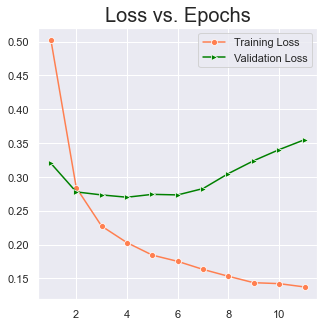

33/33 [==============================] - 0s 2ms/step - loss: 0.3550 - accuracy: 0.9190
Testing Accuracy:  91.89704656600952

Train dataset shape: (25169, 65136), 
Test dataset shape: (1049, 65136)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88370, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00002: val_accuracy improved from 0.88370 to 0.90944, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00003: val_accuracy improved from 0.90944 to 0.91706, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00004: val_accuracy did not improve from 0.91706

Epoch 00005: val_accuracy improved from 0.91706 to 0.92278, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 00006: val_accuracy improved from 0.92278 to 0.92755, saving model to models\binary_classfiier\dl\merged_descr\model_12.h5

Epoch 000

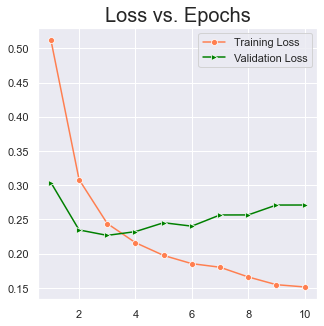

33/33 [==============================] - 0s 3ms/step - loss: 0.2567 - accuracy: 0.9285
Testing Accuracy:  92.85033345222473

Train dataset shape: (25169, 64494), 
Test dataset shape: (1049, 64494)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87512, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00002: val_accuracy improved from 0.87512 to 0.89895, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00003: val_accuracy improved from 0.89895 to 0.90658, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00004: val_accuracy improved from 0.90658 to 0.91230, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00005: val_accuracy improved from 0.91230 to 0.91516, saving model to models\binary_classfiier\dl\merged_descr\model_13.h5

Epoch 00006: val_accuracy did not improve from 0.91516

Epoch 000

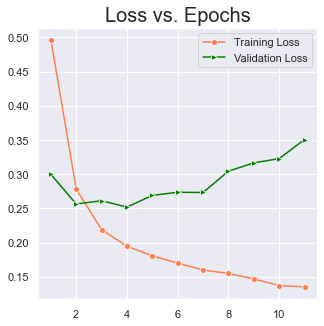

33/33 [==============================] - 0s 3ms/step - loss: 0.3165 - accuracy: 0.9228
Testing Accuracy:  92.2783613204956

Train dataset shape: (25169, 64970), 
Test dataset shape: (1049, 64970)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88656, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00002: val_accuracy improved from 0.88656 to 0.91134, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00003: val_accuracy improved from 0.91134 to 0.91516, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00004: val_accuracy improved from 0.91516 to 0.91992, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00005: val_accuracy improved from 0.91992 to 0.93327, saving model to models\binary_classfiier\dl\merged_descr\model_14.h5

Epoch 00006: val_accuracy did not improve from 0.93327

Epoch 0000

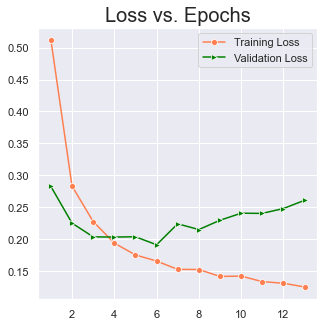

33/33 [==============================] - 0s 3ms/step - loss: 0.2482 - accuracy: 0.9428
Testing Accuracy:  94.28026676177979

Train dataset shape: (25169, 65069), 
Test dataset shape: (1049, 65069)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87703, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00002: val_accuracy improved from 0.87703 to 0.90372, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00003: val_accuracy improved from 0.90372 to 0.90944, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00004: val_accuracy improved from 0.90944 to 0.92564, saving model to models\binary_classfiier\dl\merged_descr\model_15.h5

Epoch 00005: val_accuracy did not improve from 0.92564

Epoch 00006: val_accuracy did not improve from 0.92564

Epoch 00007: val_accuracy did not improve from 0.92564

Epoch 00008: val_accuracy d

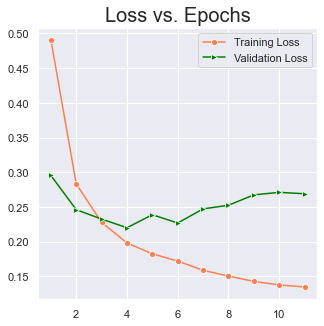

33/33 [==============================] - 0s 3ms/step - loss: 0.2712 - accuracy: 0.9266
Testing Accuracy:  92.65967607498169

Train dataset shape: (25169, 64980), 
Test dataset shape: (1049, 64980)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87703, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00002: val_accuracy improved from 0.87703 to 0.89133, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00003: val_accuracy improved from 0.89133 to 0.89704, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00004: val_accuracy improved from 0.89704 to 0.90276, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 00005: val_accuracy did not improve from 0.90276

Epoch 00006: val_accuracy improved from 0.90276 to 0.90848, saving model to models\binary_classfiier\dl\merged_descr\model_16.h5

Epoch 000

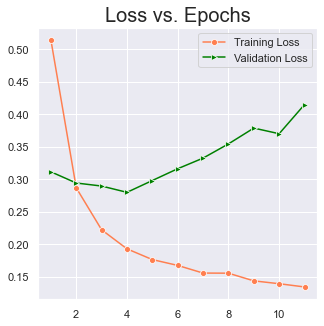

33/33 [==============================] - 0s 2ms/step - loss: 0.3698 - accuracy: 0.9199
Testing Accuracy:  91.9923722743988

Train dataset shape: (25169, 64994), 
Test dataset shape: (1049, 64994)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87798, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00002: val_accuracy improved from 0.87798 to 0.90848, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00003: val_accuracy improved from 0.90848 to 0.91230, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00004: val_accuracy improved from 0.91230 to 0.91611, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00005: val_accuracy improved from 0.91611 to 0.91706, saving model to models\binary_classfiier\dl\merged_descr\model_17.h5

Epoch 00006: val_accuracy did not improve from 0.91706

Epoch 0000

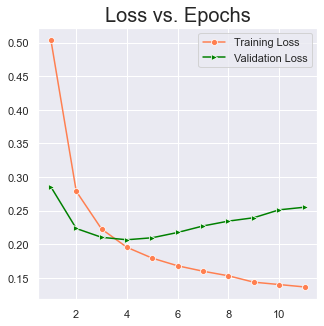

33/33 [==============================] - 0s 3ms/step - loss: 0.2552 - accuracy: 0.9237
Testing Accuracy:  92.37368702888489

Train dataset shape: (25169, 65210), 
Test dataset shape: (1049, 65210)

Features Train dataset shape: (25169, 15000), 
FeaturesTest dataset shape: (1049, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87703, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00002: val_accuracy improved from 0.87703 to 0.89704, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00003: val_accuracy improved from 0.89704 to 0.91611, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00004: val_accuracy did not improve from 0.91611

Epoch 00005: val_accuracy improved from 0.91611 to 0.91992, saving model to models\binary_classfiier\dl\merged_descr\model_18.h5

Epoch 00006: val_accuracy did not improve from 0.91992

Epoch 00007: val_accuracy did not improve from 0.91992

Epoch 00008: val_accuracy d

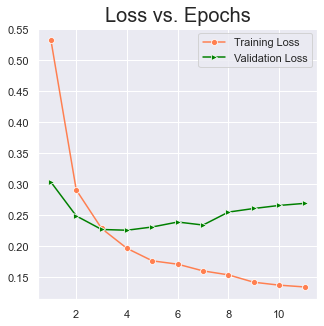

33/33 [==============================] - 0s 3ms/step - loss: 0.2608 - accuracy: 0.9218
Testing Accuracy:  92.18302965164185

Train dataset shape: (25170, 64680), 
Test dataset shape: (1048, 64680)

Features Train dataset shape: (25170, 15000), 
FeaturesTest dataset shape: (1048, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88836, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00002: val_accuracy improved from 0.88836 to 0.90744, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00003: val_accuracy improved from 0.90744 to 0.91317, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00004: val_accuracy improved from 0.91317 to 0.91794, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 00005: val_accuracy did not improve from 0.91794

Epoch 00006: val_accuracy improved from 0.91794 to 0.92271, saving model to models\binary_classfiier\dl\merged_descr\model_19.h5

Epoch 000

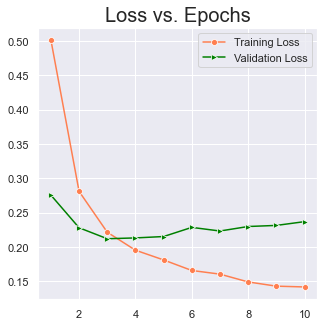

33/33 [==============================] - 0s 3ms/step - loss: 0.2316 - accuracy: 0.9370
Testing Accuracy:  93.70229244232178

Train dataset shape: (25170, 65190), 
Test dataset shape: (1048, 65190)

Features Train dataset shape: (25170, 15000), 
FeaturesTest dataset shape: (1048, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88550, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00002: val_accuracy improved from 0.88550 to 0.91508, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00003: val_accuracy did not improve from 0.91508

Epoch 00004: val_accuracy improved from 0.91508 to 0.92080, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00005: val_accuracy improved from 0.92080 to 0.92653, saving model to models\binary_classfiier\dl\merged_descr\model_20.h5

Epoch 00006: val_accuracy did not improve from 0.92653

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.

Ep

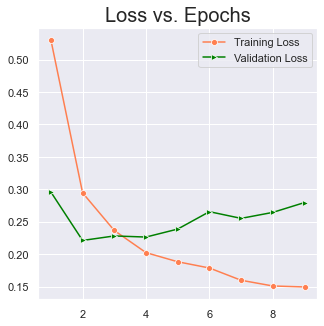

33/33 [==============================] - 0s 3ms/step - loss: 0.2388 - accuracy: 0.9265
Testing Accuracy:  92.65267252922058

Train dataset shape: (25170, 65139), 
Test dataset shape: (1048, 65139)

Features Train dataset shape: (25170, 15000), 
FeaturesTest dataset shape: (1048, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88931, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00002: val_accuracy improved from 0.88931 to 0.91794, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00003: val_accuracy improved from 0.91794 to 0.92366, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00004: val_accuracy improved from 0.92366 to 0.92653, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 00005: val_accuracy did not improve from 0.92653

Epoch 00006: val_accuracy improved from 0.92653 to 0.92939, saving model to models\binary_classfiier\dl\merged_descr\model_21.h5

Epoch 000

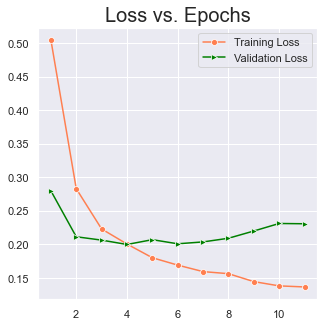

33/33 [==============================] - 0s 3ms/step - loss: 0.2198 - accuracy: 0.9342
Testing Accuracy:  93.41602921485901

Train dataset shape: (25170, 64576), 
Test dataset shape: (1048, 64576)

Features Train dataset shape: (25170, 15000), 
FeaturesTest dataset shape: (1048, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88550, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00002: val_accuracy improved from 0.88550 to 0.90935, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00003: val_accuracy improved from 0.90935 to 0.92080, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00004: val_accuracy improved from 0.92080 to 0.93225, saving model to models\binary_classfiier\dl\merged_descr\model_22.h5

Epoch 00005: val_accuracy did not improve from 0.93225

Epoch 00006: val_accuracy did not improve from 0.93225

Epoch 00007: val_accuracy did not improve from 0.93225

Epoch 00007: ReduceLROnPlat

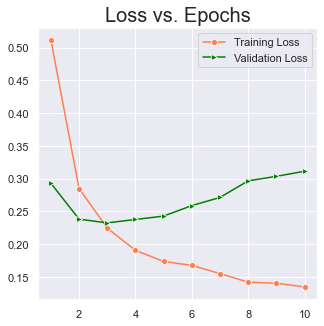

33/33 [==============================] - 0s 3ms/step - loss: 0.2376 - accuracy: 0.9323
Testing Accuracy:  93.22519302368164

Train dataset shape: (25170, 65209), 
Test dataset shape: (1048, 65209)

Features Train dataset shape: (25170, 15000), 
FeaturesTest dataset shape: (1048, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87882, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00002: val_accuracy improved from 0.87882 to 0.89695, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00003: val_accuracy improved from 0.89695 to 0.90553, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00004: val_accuracy did not improve from 0.90553

Epoch 00005: val_accuracy improved from 0.90553 to 0.90744, saving model to models\binary_classfiier\dl\merged_descr\model_23.h5

Epoch 00006: val_accuracy did not improve from 0.90744

Epoch 00007: val_accuracy improved from 0.90744 to 0.90935, saving model to models\

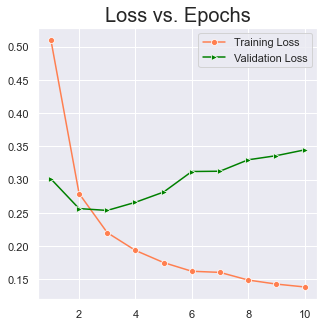

33/33 [==============================] - 0s 3ms/step - loss: 0.3127 - accuracy: 0.9094
Testing Accuracy:  90.93511700630188

Train dataset shape: (25170, 64986), 
Test dataset shape: (1048, 64986)

Features Train dataset shape: (25170, 15000), 
FeaturesTest dataset shape: (1048, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.88359, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00002: val_accuracy improved from 0.88359 to 0.90172, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00003: val_accuracy improved from 0.90172 to 0.91508, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00004: val_accuracy improved from 0.91508 to 0.92176, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00005: val_accuracy improved from 0.92176 to 0.92366, saving model to models\binary_classfiier\dl\merged_descr\model_24.h5

Epoch 00006: val_accuracy improved from 0.92366 to 0.92844, savin

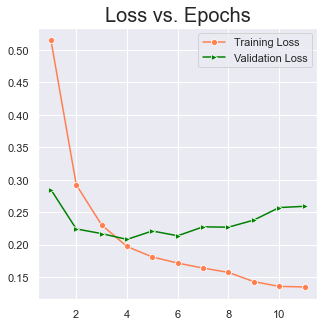

33/33 [==============================] - 0s 3ms/step - loss: 0.2270 - accuracy: 0.9332
Testing Accuracy:  93.32060813903809

Train dataset shape: (25170, 65131), 
Test dataset shape: (1048, 65131)

Features Train dataset shape: (25170, 15000), 
FeaturesTest dataset shape: (1048, 15000)

Epoch 00001: val_accuracy improved from -inf to 0.87023, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00002: val_accuracy improved from 0.87023 to 0.89027, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00003: val_accuracy improved from 0.89027 to 0.90076, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00004: val_accuracy improved from 0.90076 to 0.90458, saving model to models\binary_classfiier\dl\merged_descr\model_25.h5

Epoch 00005: val_accuracy did not improve from 0.90458

Epoch 00006: val_accuracy did not improve from 0.90458

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.

Ep

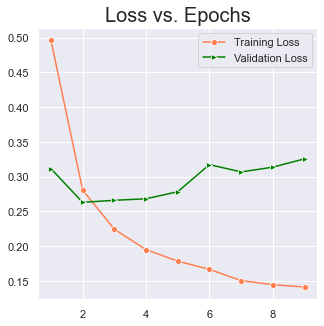

33/33 [==============================] - 0s 3ms/step - loss: 0.3257 - accuracy: 0.9151
Testing Accuracy:  91.50763154029846


In [67]:
from pathlib import Path
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_extraction.text import TfidfVectorizer


def get_model_name(k):
    return f'model_{k}.h5'

NUM_SPLITS = 25
EPOCHS = 50
save_dir = Path('./models/binary_classfiier/dl/merged_descr')
fold_var = 1
NGRAM_RANGE = (1, 2)
TOP_K = 15000
TOKEN_MODE = 'word'
MIN_DOC_FREQ = 2
NUM_CLASSES = 2

kwargs = {
        'ngram_range' : NGRAM_RANGE,
        'dtype' : 'int32',
        'strip_accents' : 'unicode',
        'decode_error' : 'replace',
        'analyzer' : TOKEN_MODE,
        'min_df' : MIN_DOC_FREQ
    }

val_accs = []
skf = StratifiedKFold(n_splits=NUM_SPLITS, shuffle=True, random_state=seed)

for train_indices, test_indices in skf.split(X, y):
    X_train_split, X_test_split = X[train_indices], X[test_indices]
    y_train_split, y_test_split = y[train_indices], y[test_indices]
    vectorizer = TfidfVectorizer(**kwargs)
    X_train_vec = vectorizer.fit_transform(X_train_split)
    X_test_vec = vectorizer.transform(X_test_split)
    print(f"\nTrain dataset shape: {X_train_vec.shape}, \nTest dataset shape: {X_test_vec.shape}")

    selector = SelectKBest(f_classif, k=min(TOP_K, X_train_vec.shape[1]))
    selector.fit(X_train_vec, y_train_split)
    X_train_vec = selector.transform(X_train_vec).astype('float32')
    X_test_vec = selector.transform(X_test_vec).astype('float32')
    X_train_vec = X_train_vec.toarray()
    X_test_vec = X_test_vec.toarray()

    print(f"\nFeatures Train dataset shape: {X_train_vec.shape}, \nFeaturesTest dataset shape: {X_test_vec.shape}")
    model_ = None
    model_ = Sequential([   
        Dense(30, activation='relu', input_shape=X_train_vec.shape[1:]),
        Dropout(0.5),
        Dense(20, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model_.compile(
        loss = 'binary_crossentropy',
        optimizer = 'adam',
        metrics = ['accuracy']
    )
    
    checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(save_dir / get_model_name(fold_var),
                                                            monitor='val_accuracy',
                                                            verbose=1,
                                                            save_best_only=True,
                                                            mode='max')

    h_ = model_.fit(
            X_train_vec, y_train_split,
            validation_data = (X_test_vec, y_test_split),  # do not use the test data for validation to prevent data leakage, we only use to test at the model in the end
            epochs = EPOCHS,
            callbacks = [checkpoint, early_stop, lr_reduce_on_plateau],
            verbose = False)
    
    model_.load_weights(save_dir / get_model_name(fold_var))
    plot_learning_curve(h_)
    loss, acc = model_.evaluate(X_test_vec, y_test_split)
    print("Testing Accuracy: ", acc*100)
    val_accs.append(acc)
    tensorflow.keras.backend.clear_session()
    fold_var += 1

In [68]:
print("Testing Accuracy: ", np.mean(val_accs)*100)   # average k fold accuracy

Testing Accuracy:  92.56239318847656


<h3><ul>
    <li><strong><span style="font-family: 'Trebuchet MS', Helvetica, sans-serif;">Metrics: </span></strong></li>
</ul></h3>

<table style="width:100%">
  <tr>
    <th>Model</th>
    <th>Test Accuracy</th>
  </tr>
  <tr>
    <td>Simple Feed-Forward Net using Embedding Layer</td>
      <td>88.63%</td>
  </tr>
<tr>
    <td>Feed-Forward NN + Batch Norm</td>
    <td>90.13%</td>
  </tr>
<tr>
    <td>Feed-Forward NN + Dropout</td>
    <td>90.21%</td>
  </tr>
    <tr>
    <td>Feed-Forward NN + Pre-trained GloVe embeddings</td>
    <td>89.12%</td>
  </tr>
  <tr>
    <td>LSTM</td>
    <td>91.58%</td>
  </tr>
    
  <tr>
    <td>Bi-Directional LSTM</td>
    <td>91.33%</td>
  </tr>
<tr>
    <td>Convolution Blocks (Dimensionality Reduction) + LSTM</td>
    <td>91.66%</td>
  </tr>
    <tr>
    <td>Convolution Blocks (Dimensionality Reduction) + Bi-LSTM</td>
    <td>91.69%</td>
  </tr>
<tr>
    <td>TfIdf Vectors + Feature Selection + Feed-forward Neural Net</td>
    <td>84.74%</td>
  </tr>
<tr>
    <td>Stratified KFold Validation + TfIdf Vectors + Feature Selection + Feed-forward Neural Net</td>
    <td>92.56%</td>
  </tr>
</table>